# MNIST Digit Recognition Dataset\n

This notebook contains two models trained on the MNIST digit recognition dataset. First we import the data (in this case we will use a CSV file available at: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv) and then we will visualize it. Next we perform some exploratory data analysis, by performing a t-Distributed Stochastic Neighbor Embedding (t-SNE) decomposition. This allows high dimensional datasets to be visualized in in a lower dimensional space. After this we need to do some data processing before we train any models. After this we will train some models, these are

- A simple 3-layer MLP neural network
- A CNN where we try to improve accuracy

The start of this notebook, including the t-SNE, uses ideas from Abhishek Tharkur's book 'Approaching (Almost) Any Machine Learning Problem'. The basis for the first neural network comes from a Kaggle notebook by Prashant Banerje: https://www.kaggle.com/code/prashant111/mnist-deep-neural-network-with-keras


### Import Required Modules

First we will import the required modules.

In [1]:
# these first modules are used to train the models
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_openml
from sklearn import manifold
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from keras.layers import Conv2D
from keras.regularizers import l2
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping

# these modules are used for data manipulation
import numpy as np
import pandas as pd

# these modules are used for plotting
import seaborn as sns
import matplotlib.pyplot as plt

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

C:\Users\isaac\anaconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Import the Data

Next we will import the data. These come as CSV files (available at: https://www.kaggle.com/datasets/oddrationale/mnist-in-csv). These are already split into training and test datasets. The training dataset holds 60,000 examples to train on, while the test dataset consists of 10,000 examples to validate the models. We will use pandas to import the data and create two DataFrames, one for the training data and the other for the test data.

In [2]:
data_train = pd.read_csv('data/MNIST/mnist_train.csv')
data_test = pd.read_csv('data/MNIST/mnist_test.csv')
data_test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Visualize the Data

The data format isn't very readable. In our dataframes we have values for each pixel in the 28x28 pixel image and a label telling us which digit the picture represents. To visualize these a little better, we can reshape the data and plot the values.

this is an image of a 5:


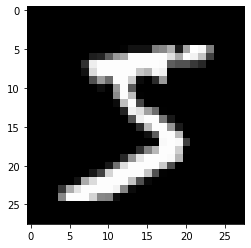

In [3]:
df_index = 0 # this is the dataframe index which can be changed to view different digits
digit = data_train.loc[df_index, '1x1':'28x28'] # select only the pixel values
digit_np = np.asarray(digit) # convert to numpy array
single_image = digit_np.reshape(28, 28) # reshape to 28x28

# plot results
plt.imshow(single_image, cmap='gray')
print('this is an image of a ' + str(data_train.loc[df_index, 'label']) + ':')

### Exploratory Data Analysis

We now perform a t-Distributed Stochastic Neighbor Embedding (t-SNE) decomposition of the data. Here we reduce the dimensionality of the dataset so that we can visualize and color the points by their class (i.e. 0 to 9). Similar examples will be plotted near one another, regardless of their label.

Here we consider all the examples, this takes some time to fit. The same results can be achieved by considering less examples, however care must be taken to ensure these are representative to the total dataset.

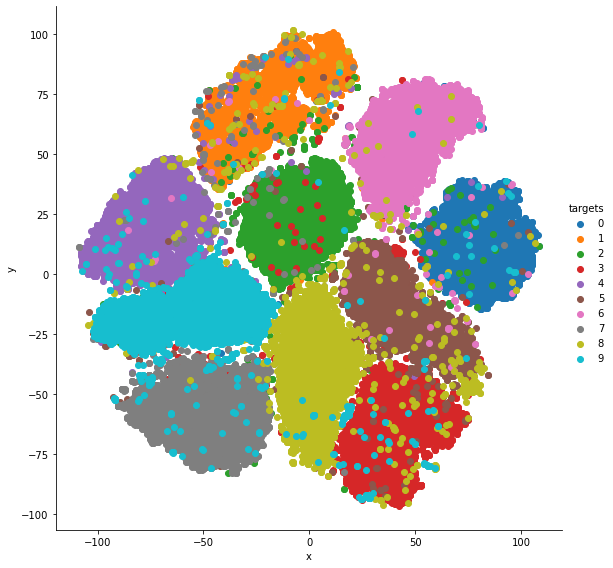

In [7]:
pixel_values = data_train.loc[:, '1x1':'28x28'] # data processing is similar to cell above, but now we select all rows 
pixel_values_np = np.asarray(pixel_values)

# perform the t-SNE
tsne = manifold.TSNE(n_components=2,      # this will plot our data in a 2D setting
                     random_state=42,
                     init='random',
                     learning_rate='auto'
                    )
transformed_data = tsne.fit_transform(pixel_values_np[:, :])

# convert to dataframe
tsne_df = pd.DataFrame(np.column_stack((transformed_data, data_train['label'])),
                       columns=["x", "y", "targets"]
                      )

# plotting the results
tsne_df.loc[:, "targets"] = tsne_df.targets.astype(int)
grid = sns.FacetGrid(tsne_df, hue="targets", height=8)
grid.map(plt.scatter, "x", "y").add_legend()

As we can see from the results, the classes form clear groups. This means there is a similarity between the majority of examples in each class, this is good grounds to proceed and train a model. Of course, some examples plot nearer other classes, this is to be expected and makes sense (how many times have asked \"is that a 3 or a 2?\" when reading back someone’s handwritten phone number?). This mean we also expect our model’s accuracy to be below 100%, as is typical.

### Data Processing

Before we train our models, we need to process the data.

In [18]:
# split the datasets into X (pixel values) and y (labels)
X_train = data_train.loc[:, data_train.columns != 'label']
X_test = data_test.loc[:, data_test.columns != 'label']
y_train = data_train.loc[:, data_train.columns == 'label']
y_test = data_test.loc[:, data_test.columns == 'label']

# noramlize the X data
# currently values for X (pixel values) are between 0 and 255. This can cause issues when
# the model learns and therefore we scale the data between 0.0 and 1.0.
# this can simply be done by dividing all values of X by 255.
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# convert y to categorical
# the labels are an integer between 0 and 9, again this is not suitable as an output for the model.
#Here we convert to a one-hot vector where each class is represented as a vector.
#The base vector is 1x10, all values are 0 expect the index of the digit class.
#For examples 8 is now represented as [0,0,0,0,0,0,0,1,0]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Model 1: 3-layer MLP Neural Network

The basis for this model comes from Prashant Banerje's Kaggle notebook: https://www.kaggle.com/code/prashant111/mnist-deep-neural-network-with-keras

### Parameters
Before we build and train our network, first we define some parameters:
- Input size: The shape of our X data will define the input size of the first layer
- Number of labels: This will define the output layer of the network (for our data this is 10)
- Batch size: The amount of data used for each update of the model parameters (iteration)
- Hidden units: Number of hidden units in the model's architecture

In [19]:
input_size = X_train.shape[1]
num_labels = len(np.unique(data_train.loc[:, data_train.columns == 'label']))
batch_size = 256
hidden_units = 128

### Model Architecture

We are now ready to define the model architecture. We will use standard dense layers, where the size is defined from the parameters above. The first two layers will have ReLU activation, while the output later will have ‘softmax’ (this converts the output vector to a vector of probabilities).

In [20]:
model = Sequential()
# layer 1
model.add(Dense(hidden_units,
                input_dim=input_size))
model.add(Activation('relu'))

# layer 2
model.add(Dense(hidden_units))
model.add(Activation('relu'))

# layer 3
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 activation_3 (Activation)   (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 activation_4 (Activation)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
 activation_5 (Activation)   (None, 10)                0         
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-tr

### Compile the Model

Now we compile our model. We choose categorical crossentropy as our loss function, this is often used for classification problems with more than two classes (multi-class). For our metrics we choose accuracy and this will be used to validate and compare models. Accuracy is defined as:

<br>
<p style="text-align: center;">Accuracy = Number of Correct Predictions / Total Number of Predicitions</p>
<br>
We also choose 'Adam' as our optimizer. This is considered to be a robust optimizer that is efficient, even on large datasets.

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy']
             )

### Fitting the Model

We call `model.fit` to train the model. Here we define:
- Training data: Our `X_train`, `y_train`
- Epochs: The number of epochs is the total amount of times fitting will cycle through the data
- Batch size: As defined in Parameters
- Validation split: We will use some of our dataset to use to validate the model after each epoch. This helps to monitor the fitting. (Note: This is different to out `X_test` and `y_test` datasets which will be used to validate the final model)

We will train for 50 epochs and use 20% of our dataset for validation after each epoch.

In [22]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=batch_size,
          validation_split=0.1,
         )

Epoch 1/50
211/211 [==============================] - 5s 25ms/step - loss: 0.4262 - accuracy: 0.8801 - val_loss: 0.1726 - val_accuracy: 0.9517
Epoch 2/50
211/211 [==============================] - 5s 25ms/step - loss: 0.1677 - accuracy: 0.9501 - val_loss: 0.1149 - val_accuracy: 0.9687
Epoch 3/50
211/211 [==============================] - 5s 25ms/step - loss: 0.1146 - accuracy: 0.9667 - val_loss: 0.0983 - val_accuracy: 0.9705
Epoch 4/50
211/211 [==============================] - 5s 26ms/step - loss: 0.0877 - accuracy: 0.9742 - val_loss: 0.0903 - val_accuracy: 0.9728
Epoch 5/50
211/211 [==============================] - 5s 26ms/step - loss: 0.0698 - accuracy: 0.9795 - val_loss: 0.0873 - val_accuracy: 0.9738
Epoch 6/50
211/211 [==============================] - 5s 25ms/step - loss: 0.0567 - accuracy: 0.9839 - val_loss: 0.0828 - val_accuracy: 0.9735
Epoch 7/50
211/211 [==============================] - 5s 25ms/step - loss: 0.0474 - accuracy: 0.9866 - val_loss: 0.0773 - val_accuracy: 0.9770

### Accuracy and Loss

Now we have trained the model we can plot out the accuracy, of both training data and validation data and do the same for loss.

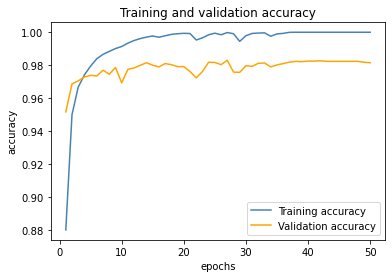

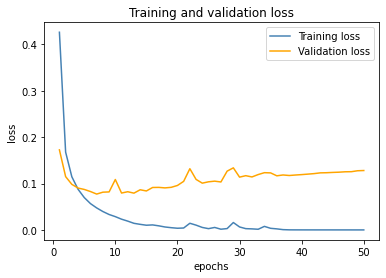

<Figure size 432x288 with 0 Axes>

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, c='steelblue',  label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, c='steelblue', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.figure()\

plt.show()

We can see that accuracy of the training data is always higher than the validation set, which is to be expected. For loss this is the other way round. The validation loss does slightly increase over the epochs, this could suggest some overfitting and we’ll address this with the next model.

### Model Accuracy

Now we can evaluate the models accuracy.

In [26]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test accuracy: ' + str(round((accuracy * 100.0), 2)))

40/40 [==============================] - 1s 13ms/step - loss: 0.1035 - accuracy: 0.9822
Test accuracy: 98.22


A score of 98.2% is not bad, considering this is a fairly simple network.


## Model 2: Convolutional Neural Network

Now we have a working neural network model, lets see if we can improve our accuracy score (98.6%) by making some changes. The major change will be moving over to a CNN (convolutional neural network). Also, we will make some changes to reduce chances of overfitting.
 
 At this point many models begin to look quite simular. I have added some links that also descirbe high accuracy models:
- https://towardsdatascience.com/going-beyond-99-mnist-handwritten-digits-recognition-cfff96337392
- https://medium.com/analytics-vidhya/getting-it-to-top-6-in-kaggles-mnist-digit-recognizer-from-scratch-3-8b11b79958a2


### Data Processing

Although most data processing remains the same, we need to reshape the X data (pixels). The benefit of the CNN is that it doesn’t need to consider the whole image, instead it can use features from within the image. Therefore however, we need to reshape out data to ( 60000, 28, 28), rather than the flattered dataset (60000, 784). The other parts of the data processing remain the same as before.

In [27]:
X_train = data_train.loc[:, data_train.columns != 'label']
X_test = data_test.loc[:, data_test.columns != 'label']
y_train = data_train.loc[:, data_train.columns == 'label']
y_test = data_test.loc[:, data_test.columns == 'label']

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# reshape the X_train and X_test
X_train = np.asarray(X_train)
X_train = X_train.reshape( -1, 28, 28)
X_test = np.asarray(X_test)
X_test = X_test.reshape( -1, 28, 28)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Model Architecture

We can now build our new CNN model. We start, as before, by defining some parameters. The input size is the new shape of the X_train data and the number of labels remains the same. We reduce the bath size down to 64, meaning the model will update weights after seeing 64 examples. Hidden units have increased to 256 allowing for a wider network (this is sometimes doubled in some layers). We also now have dropout (set at 0.3). Here we use drop out after some of the layers to remove some neurons, this encourages the model not to rely solely on specific neurons during training, and therefore helps to reduce over fitting. We also use regularization in the model, which reduces the weights of the neurons towards zero, this also helps reduce overfitting on the training data. To also aid in reducing overfitting we also add batch normalization, this adds a layer to the network that standardizes the inputs to a layer, which helps reduce the number of epochs we need to train. It should be noted that dropout and regularization techniques do not directly improve the accuracy on the test dataset, they help prevent overfitting.

The model architecture has also changed, firstly as discussed we now use convolutional layers (Conv2D), which allows features within the images to be utilised. This is done by applying a filter to the image and creating a feature map. We also add layers and hidden units to make a wider and deep model.

These changes will hopefully improve out accuracy, but we pay a large price in training time.

In [29]:
# define parameters
input_size = X_train.shape[1]
print(input_size)
num_labels = len(np.unique(data_train.loc[:, data_train.columns == 'label']))
batch_size = 64
hidden_units = 256
dropout = 0.3

# model architecture
model = Sequential()

# layer 1
model.add(Conv2D(filters = 32, kernel_size = 5, strides = 1,
       activation = 'relu', input_shape = (28, 28, 1), kernel_regularizer=l2(0.0005)))

#layer 2
model.add(Conv2D(hidden_units, kernel_size = 3, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(dropout))

# layer 3
model.add(Conv2D((hidden_units*2), kernel_size = 3, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(dropout))

#layer4
model.add(Conv2D((hidden_units*2), kernel_size = 3, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(dropout))

#dense layers
#layer 5
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(dropout))

# layer 6
model.add(Dense((hidden_units*2),activation='relu', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(dropout))

#layer 7
model.add(Dense((hidden_units*2),activation='relu', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(dropout))

# layer 8
model.add(Dense(num_labels, activation='softmax'))

model.summary()

28
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 256)       73984     
                                                                 
 batch_normalization_6 (Batc  (None, 22, 22, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 11, 11, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 512)     

### Fitting the Model

We can now compile the model, the same as before. However, this time we are not using the ‘Adam’ optimizer, this is because we now introduce a variable learning rate. This will monitor our validation loss and reduce the learning rate by 0.5. when there is no change in this metric. It will wait 2 epochs before reducing the learning rate to make sure it has plateaued.

After this we can fit the model.

In [30]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy']
             )

from keras.callbacks import ReduceLROnPlateau
variable_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=2,
                                mode='min',
                                min_delta=0.001,
                                cooldown=0,
                                min_lr=0,
                                verbose=1
                               )

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          min_delta=1e-5,
                          mode='max',
                          restore_best_weights=True,
                          verbose=1
                          )

history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size,
                                             validation_split=0.1, callbacks=[variable_lr, early_stop])

Epoch 1/100
844/844 [==============================] - 788s 934ms/step - loss: 1.0759 - accuracy: 0.9316 - val_loss: 0.6188 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 2/100
844/844 [==============================] - 782s 927ms/step - loss: 0.5308 - accuracy: 0.9673 - val_loss: 0.3863 - val_accuracy: 0.9853 - lr: 0.0010
Epoch 3/100
844/844 [==============================] - 781s 926ms/step - loss: 0.4180 - accuracy: 0.9700 - val_loss: 0.3993 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 4/100
844/844 [==============================] - 760s 901ms/step - loss: 0.3827 - accuracy: 0.9724 - val_loss: 0.3308 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 5/100
844/844 [==============================] - 764s 905ms/step - loss: 0.3721 - accuracy: 0.9723 - val_loss: 0.3236 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 6/100
844/844 [==============================] - 743s 880ms/step - loss: 0.3574 - accuracy: 0.9744 - val_loss: 0.3148 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 7/100
844/844 [===================

### Accuracy and Loss

We can view accuracy and loss in the same way as before.

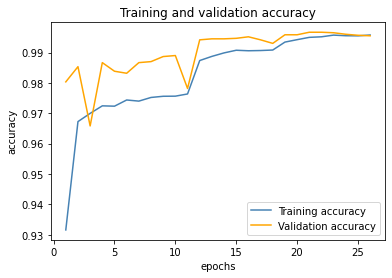

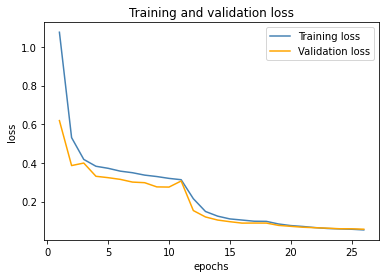

<Figure size 432x288 with 0 Axes>

In [31]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, c='steelblue',  label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, c='steelblue', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.show()

### Model Accuracy

Now we can evaluate the models accuracy as before.

In [32]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test accuracy: ' + str(round((accuracy * 100.0), 2)))

157/157 [==============================] - 21s 136ms/step - loss: 0.0687 - accuracy: 0.9957
Test accuracy: 99.57


The new model now has an accuracy of 99.6% which is an improvement on the 98.4% before. However, the trade-off has been training time and computational resources, therefore depending on the end goal one model (or a compromise) may suit better.

### Kaggle Submission

Here I have left in some code I used to submit this model to a Kaggle competition (https://www.kaggle.com/competitions/digit-recognizer/leaderboard#) which uses a slightly different dataset (still MNIST digit recognizer). At the time this model was in the top 10% with an accuracy sore of 0.99432 (on the data for the competition). I expect it has now moved down the leader board by some way as I haven’t been improving it.

In [ ]:
# y_pred = model.predict(X_test)
# print(y_pred.shape)
# y_pred = tf.math.argmax(y_pred, axis = -1)
# print(y_pred.shape)
# y_pred = pd.Series(y_pred, name='Label')
# y_pred.head()
# image_id = pd.Series(range(1,28001),name='ImageId')
# image_id.isnull().sum()
# image_id.shape
# y_pred = pd.concat([image_id,y_pred],axis=1)
# y_pred.head()
# y_pred.to_csv('submission_3.csv',index=False)